<a href="https://colab.research.google.com/github/YujanTing/CS344-MachineLearning-FinalProject/blob/main/CS_334_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# CS 334 Final Project 
created by Yujan Ting, XiaoKai Fu

Access Dataset is [here](https://www.kaggle.com/tencars/392-crypto-currency-pairs-at-minute-resolution)


Reference Links#
- Training: https://towardsdatascience.com/cryptocurrency-price-prediction-using-deep-learning-70cfca50dd3a
- Explain LSTM: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
- Dataset Prepocess: https://www.kaggle.com/sergei416/crypto-lstm
- LSTM model prediction: https://www.hindawi.com/journals/complexity/2020/6622927/tab2/
- Illustrated Guide to LSTM: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
- Understanding LSTM: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Anyone Can Learn To Code an LSTM-RNN: https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

Paper
- https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8637486




# Download data from Kaggle (within 1 minute)

In [1]:
# import dataset form kaggle
!echo "{\"username\":\"ceciliating123\",\"key\":\"aba8c518b5211d7c0ec9788dbb27ebd2\"}" > kaggle.json
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tencars/392-crypto-currency-pairs-at-minute-resolution
!mkdir ~/data
!unzip -q 392-crypto-currency-pairs-at-minute-resolution.zip -d ~/data 

 99% 1.00G/1.02G [00:13<00:00, 72.4MB/s]
100% 1.02G/1.02G [00:14<00:00, 77.8MB/s]


# Import All Necssary Library for this Project

In [34]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error # MSR for accuracy
from sklearn.metrics import mean_absolute_error #MAE for accuracy
from sklearn.metrics import mean_absolute_percentage_error # mape for accuracy
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# Data Overview

In [3]:
path_name = "~/data/btcusd.csv"
df = pd.read_csv(path_name, index_col='time')
df.index = pd.to_datetime(df.index, unit='ms')
df = df[~df.index.duplicated(keep='first')]


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df.head(1000)

,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.2500,93.3000,93.3000,93.25000,93.300000
2013-04-01 00:08:00,100.0000,100.0000,100.0000,100.00000,93.300000
2013-04-01 00:09:00,93.3000,93.3000,93.3000,93.30000,33.676862
2013-04-01 00:11:00,93.3500,93.4700,93.4700,93.35000,20.000000
2013-04-01 00:12:00,93.4700,93.4700,93.4700,93.47000,2.021627
...,...,...,...,...,...
2013-04-03 19:05:00,132.4500,132.4500,132.4500,126.22212,47.194982
2013-04-03 19:06:00,132.4500,132.4500,132.4500,132.45000,30.410887
2013-04-03 19:07:00,120.5936,120.5936,120.5936,120.59360,0.279575


In [5]:
df.describe()

,open,close,high,low,volume
count,3.630671e+06,3.630671e+06,3.630671e+06,3.630671e+06,3.630671e+06
mean,1.070860e+04,1.070862e+04,1.071435e+04,1.070285e+04,1.642471e+01
std,1.547565e+04,1.547570e+04,1.548413e+04,1.546719e+04,5.675638e+01
min,1.000000e-02,1.060000e+00,1.060000e+00,1.000000e-02,1.000000e-08
25%,6.568800e+02,6.568700e+02,6.570100e+02,6.565400e+02,5.230995e-01
50%,6.332900e+03,6.332900e+03,6.334800e+03,6.331207e+03,2.850443e+00
75%,1.019502e+04,1.019500e+04,1.019994e+04,1.019100e+04,1.202381e+01
max,6.892500e+04,6.892500e+04,6.895800e+04,6.873400e+04,7.228079e+03


# Data Feature Expansion

In [6]:
# add feature return
df['return'] = (df.close - df.open) / df.open

# add time stamp features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['minute'] = df.index.minute
df['dayofweek_num'] = df.index.dayofweek

# add lag features
df['lag_minute'] = df['close'].shift(1)
df['lag_hour']  = df['close'].shift(60)

# add ‘rolling window’ feature
df['rolling_mean'] = df['close'].rolling(window=10).mean()

# add expanding window feature
df['expanding_mean'] = df['close'].expanding(2).mean()

df = df.astype(float)
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

Text(0.5, 1.0, 'Correlation Heatmap')

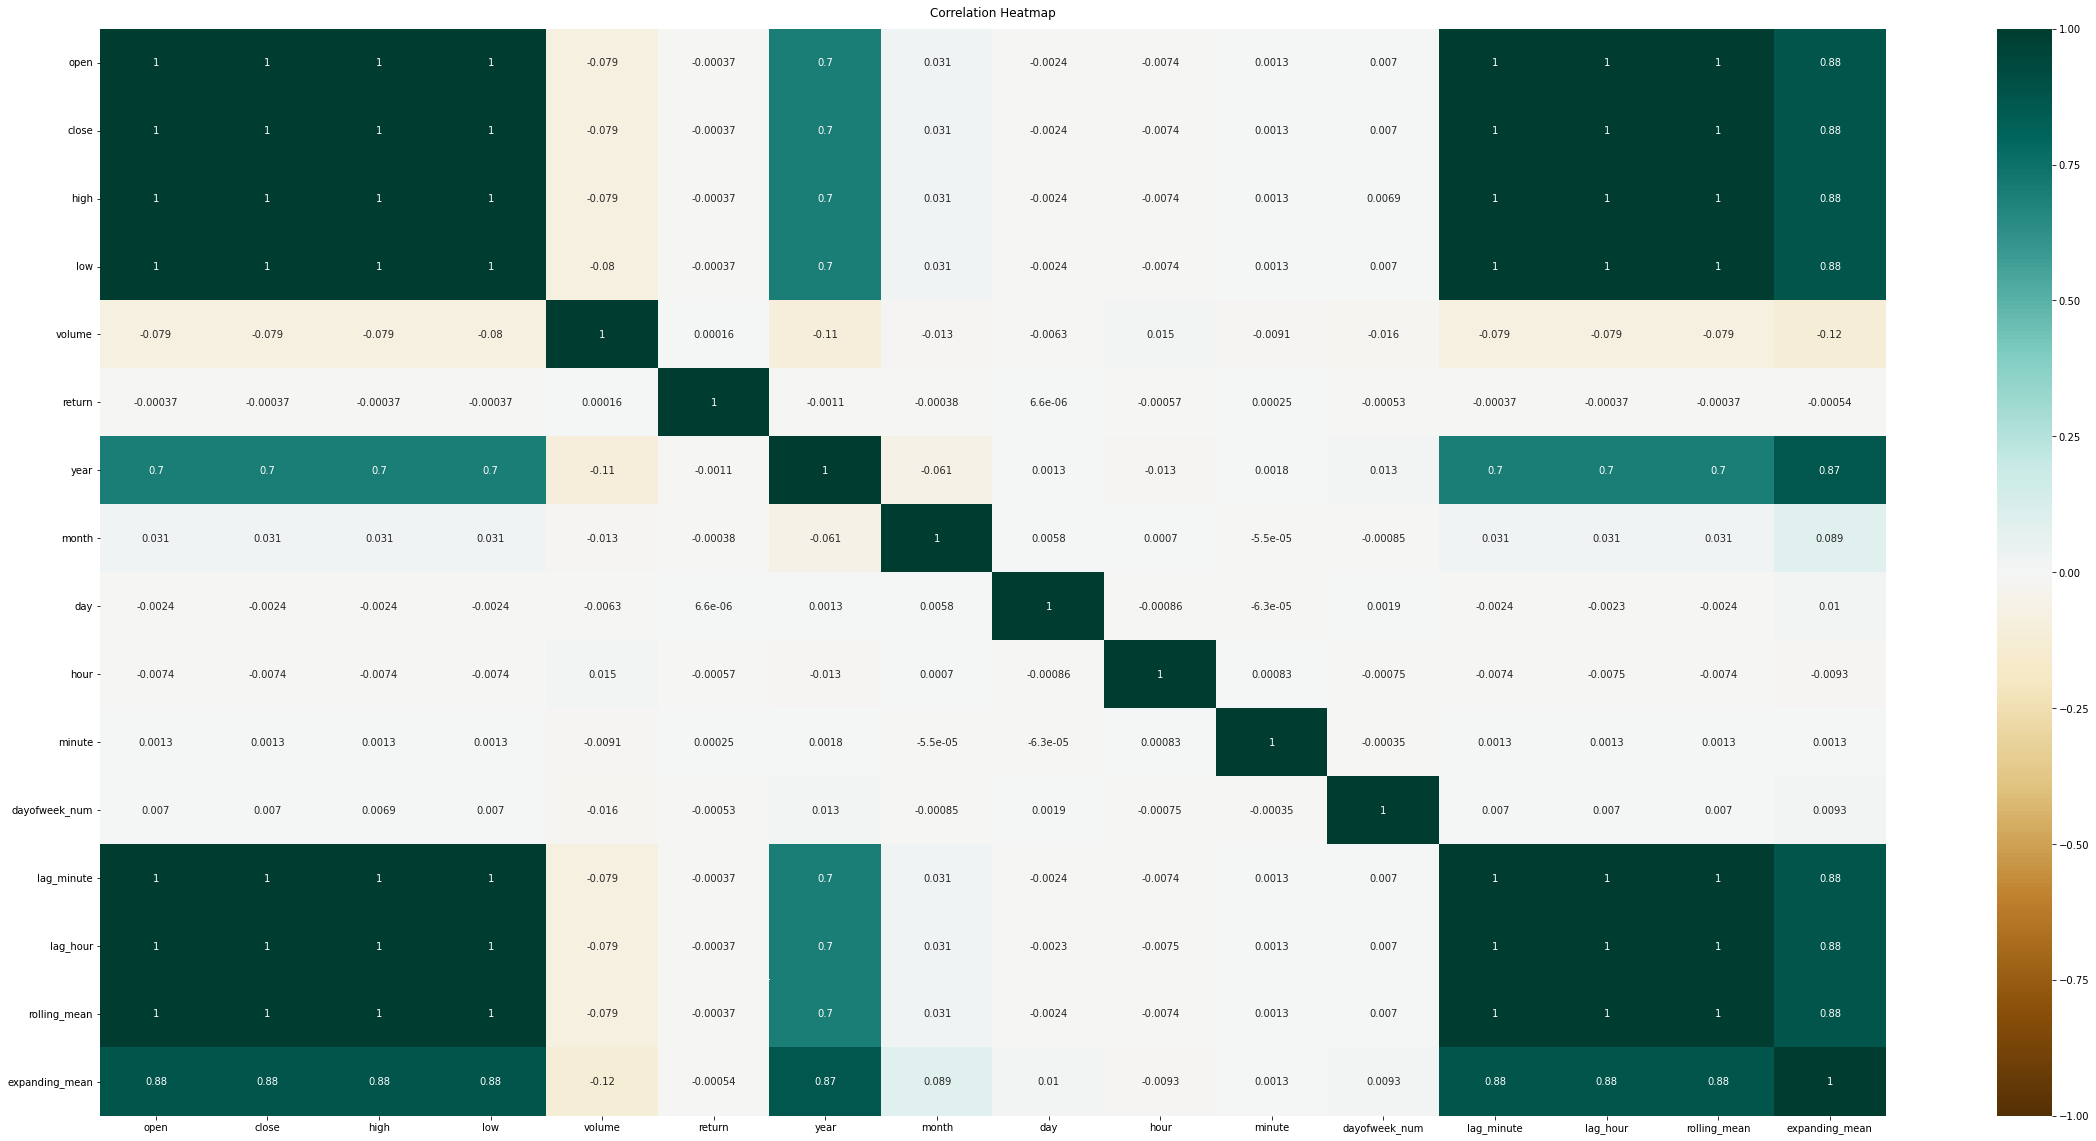

In [7]:
# compute the correlation matrix
pearson_corr = df.corr(method='pearson')
# plot the correlation matrix heatmap
plt.figure(figsize=(40, 20))
heatmap = sns.heatmap(pearson_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)

# Data Prepocess

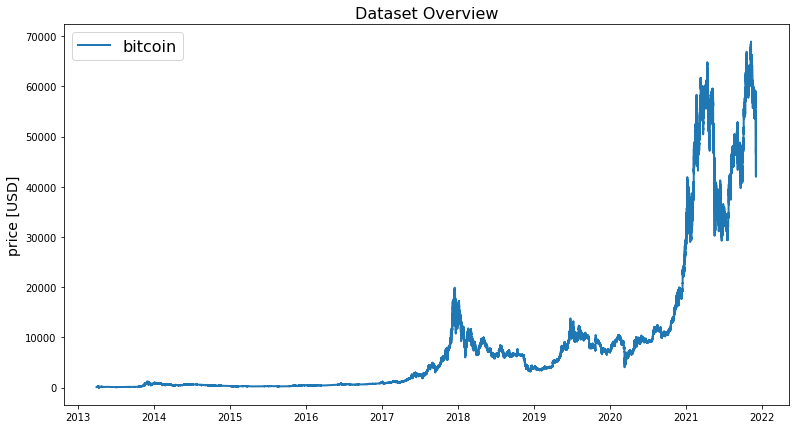

In [8]:
# plot the whole dataset
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df['close'], label='bitcoin', linewidth=2)
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Dataset Overview', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [9]:
def line_plot2(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

In [11]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

In [12]:
# split dataset
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data


In [17]:
def train_valid_test_split(df, valid_test_size=0.4):
    split_row = len(df) - int(valid_test_size * len(df))
    train_data = df.iloc[:split_row]
    valid_test_data = df.iloc[split_row:]
    valid_data, test_data = train_test_split(valid_test_data, test_size=0.5)
    return train_data, valid_data, test_data
train, valid, test = train_valid_test_split(df)



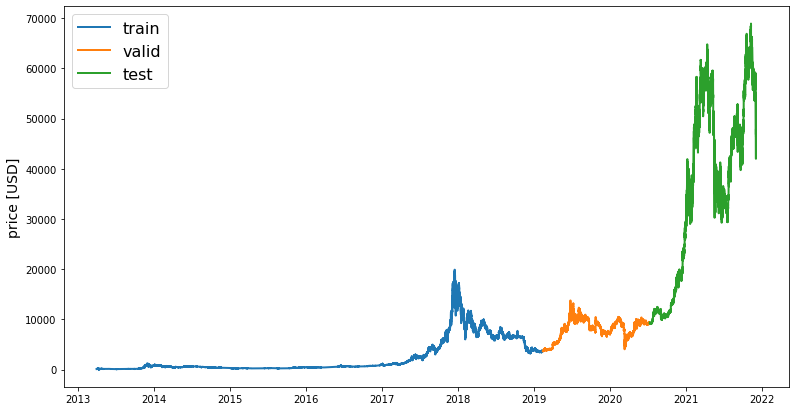

In [19]:
line_plot2(train['close'], valid['close'], test['close'], label1='train', label2='valid', label3='test', title='', lw=2)

# Select Date Range to Train

In [83]:
path_name = "~/data/btcusd.csv"
df = pd.read_csv(path_name, index_col='time')
df.index = pd.to_datetime(df.index, unit='ms')
df = df[~df.index.duplicated(keep='first')]
date_df = df.loc[(df.index >= '2019-04-01 00:00:00') & (df.index <'2019-05-02 00:00:00')]
# date_df = date_df.drop(['return','year', 'month', 'day', 'hour', 'minute', 'dayofweek_num', 'lag_minute', 'lag_hour', 'rolling_mean', 'expanding_mean'], axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [84]:
date_df

,open,close,high,low,volume
time,,,,,
2019-04-01 00:00:00,4167.500000,4168.10000,4168.100000,4167.5,54.792000
2019-04-01 00:01:00,4168.097772,4168.06024,4168.097772,4168.0,0.411137
2019-04-01 00:02:00,4168.000000,4168.00000,4168.060240,4168.0,34.196211
2019-04-01 00:03:00,4168.060240,4168.00000,4168.060240,4168.0,0.041862
2019-04-01 00:04:00,4168.060240,4168.00000,4168.060240,4168.0,0.144815
...,...,...,...,...,...
2019-05-01 23:55:00,5629.500000,5629.60000,5629.600000,5629.5,0.009233
2019-05-01 23:56:00,5629.600000,5629.60000,5629.600000,5629.5,4.840119
2019-05-01 23:57:00,5629.600000,5629.60000,5629.600000,5629.6,0.084661


# Train: using Native LSTM Model to train

# LSTM(BASELINE) Torch Implementation

In [85]:
# Import variables
window_len = 5
valid_test_size = 0.4
target_col = 'close'
hidden_dim = 5
learning_rate = 1e-5
num_epoch = 5

In [104]:
# split dataset
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

def prepare_data(df, target_col, window_len=10, zero_base=True, valid_test_size=0.4):
    train_data, valid_data, test_data = train_valid_test_split(df, valid_test_size=valid_test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_valid = extract_window_data(valid_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_valid = valid_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_vaild =  y_valid / valid_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, valid_data, test_data, X_train, X_valid, X_test, y_train, y_valid, y_test

In [114]:
train, valid, test, X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_data(date_df, target_col, window_len=window_len, zero_base=True, valid_test_size=valid_test_size)

In [116]:
y_valid = y_valid / valid[target_col][:-window_len].values - 1

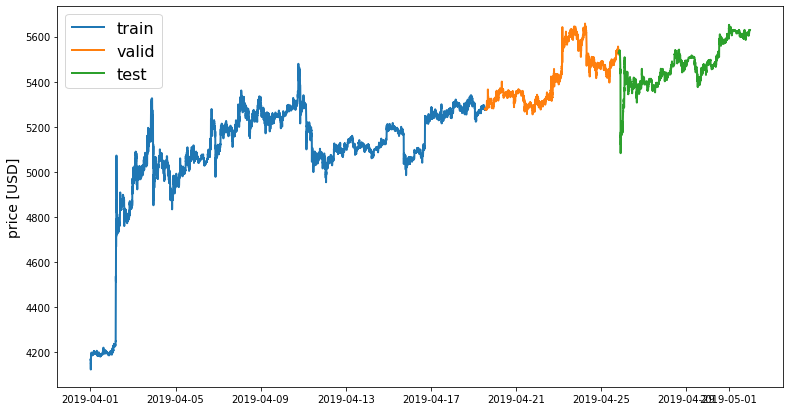

In [88]:
line_plot2(train[target_col], valid[target_col], test[target_col], 'train', 'valid', 'test', title='')

In [89]:
X = train[target_col].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.414734
p-value: 0.010467
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [90]:
X = valid[target_col].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.326006
p-value: 0.617192
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [91]:
X = test[target_col].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.139480
p-value: 0.228939
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Evaluation Metrices

In [95]:

def Eval(net, X, Y):
    loss_func = nn.MSELoss()
    total_loss = 0.0
    num_correct = 0.0
    pred_array = np.array([])
    for i in range(X.shape[0]):
        x = X_test[i, 1, :]
        x = x.astype(np.float32)
        x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
        pred = net.forward(x_tensor)
        y = torch.tensor([Y[i]], dtype=torch.float)
        loss = loss_func(torch.flatten(pred), y)
        total_loss += loss
        # num_correct += calculate_accuracy_of_sameSign(pred,y)
        pred_array = np.append(pred_array, pred.item())
    
    accuracy_of_MSE = mean_squared_error(pred_array, Y)
    print("The Mean-square-error between pred and truth: {}".format(accuracy_of_MSE)) 
    accuracy_of_RMSE = np.sqrt(mean_squared_error(pred_array, Y))
    print("The Root-mean-square-error between pred and truth: {}".format(accuracy_of_RMSE)) 
    accuracy_of_MAE = mean_absolute_error(pred_array, Y)
    print("The mean absolute error between pred and truth: {}".format(accuracy_of_MAE)) 
    accuracy_of_MAPE = mean_absolute_percentage_error(pred_array, Y)
    print("The mean absolute percentage between pred and truth: {}".format(accuracy_of_MAPE)) 

# Training Method

In [ ]:
def Train(net, X, Y, n_iter, X_valid, y_valid):
    print("Start Training!")

    optimizer = optim.Adam(net.parameters(), lr=2e-5)
    loss_func = nn.MSELoss()
    for epoch in range(n_iter):
        num_correct = 0
        total_loss = 0.0
        net.train()   #Put the network into training mode
        for i in tqdm.notebook.tqdm(range(X.shape[0])):
            x = X[i, 1, :]
            x = x.astype(np.float32)
            x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
            pred = net.forward(x_tensor)
            y = torch.tensor([Y[i]], dtype=torch.float)
            loss = loss_func(torch.flatten(pred), y)
            total_loss += loss 
            loss.backward()
            optimizer.step()
        net.eval()    
        print(f"loss on epoch {epoch} = {total_loss}")
        Eval(net, X_valid, y_valid)

#Using CPU （Baseline LSTM）

In [129]:
# Import variables
window_len = 5
test_size = 0.2
target_col = 'close'
hidden_dim = 5
learning_rate = 1e-5
num_epoch = 5

In [130]:
class LSTMBaseline(nn.Module):
    def __init__(self, sequence_dim, hidden_dim):
        super(LSTMBaseline, self).__init__()
        self.sequence_dim = sequence_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(sequence_dim, hidden_dim)
        self.hidden2target = nn.Linear(hidden_dim, 1)

    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        pred_out = self.hidden2target(lstm_out)
        return pred_out
 
lstm_baseline = LSTMBaseline(window_len, hidden_dim)
Train(lstm_baseline, X_train, y_train, num_epoch, X_valid, y_valid)
print("Final evaluation on the test data set: ")
Eval(lstm_baseline, X_test, y_test)

Start Training!


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 0 = 156.1817626953125
The Mean-square-error between pred and truth: 0.0007885080065370641
The Root-mean-square-error between pred and truth: 0.02808038472914971
The mean absolute error between pred and truth: 0.02679991842835441
The mean absolute percentage between pred and truth: 1.0115850979081507


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 1 = 12.274931907653809
The Mean-square-error between pred and truth: 0.0003085764327747382
The Root-mean-square-error between pred and truth: 0.017566343750898713
The mean absolute error between pred and truth: 0.01523966889374934
The mean absolute percentage between pred and truth: 1.0809171324807147


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 2 = 3.665325164794922
The Mean-square-error between pred and truth: 7.569940351504894e-06
The Root-mean-square-error between pred and truth: 0.002751352458611018
The mean absolute error between pred and truth: 0.001994152796524893
The mean absolute percentage between pred and truth: 2.3958518182994113


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 3 = 1.2825781106948853
The Mean-square-error between pred and truth: 1.5142429243906625e-05
The Root-mean-square-error between pred and truth: 0.0038913274398213555
The mean absolute error between pred and truth: 0.0035046794042089754
The mean absolute percentage between pred and truth: 1.5343792169737935


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 4 = 1.3277065753936768
The Mean-square-error between pred and truth: 8.147540803590297e-05
The Root-mean-square-error between pred and truth: 0.00902637291695302
The mean absolute error between pred and truth: 0.008782456074461922
The mean absolute percentage between pred and truth: 0.9984836831562806
Final evaluation on the test data set: 
The Mean-square-error between pred and truth: 8.263029886730018e-05
The Root-mean-square-error between pred and truth: 0.009090120948991833
The mean absolute error between pred and truth: 0.00879553262706112
The mean absolute percentage between pred and truth: 0.9997498539924451


In [131]:
lstm_baseline.eval()  
predictions = []
for i in range(X_test.shape[0]):
    x = X_test[i, 1, :]
    y = y_test[i]
    x = x.astype(np.float32)
    x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
    pred = lstm_baseline.forward(x_tensor)
    predictions.append(float(pred))

targets = test['close'][5:]
preds = test['close'].values[:-5] * (1 + np.array(predictions))
preds = pd.Series(index=targets.index, data=preds)

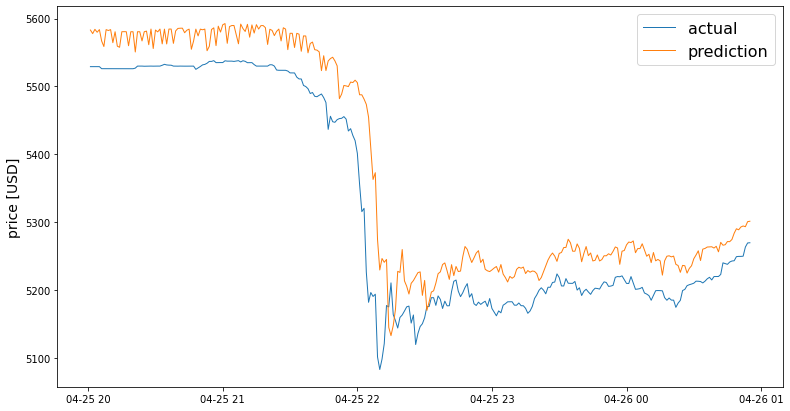

In [132]:
lstm_baseline.eval()  
predictions = []
for i in range(X_test.shape[0]):
    x = X_test[i, 1, :]
    y = y_test[i]
    x = x.astype(np.float32)
    x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
    pred = lstm_baseline.forward(x_tensor)
    predictions.append(float(pred))

targets = test['close'][5:]
preds = test['close'].values[:-5] * (1 + np.array(predictions))
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets[:-8500], preds[:-8500], 'actual', 'prediction', lw=1)

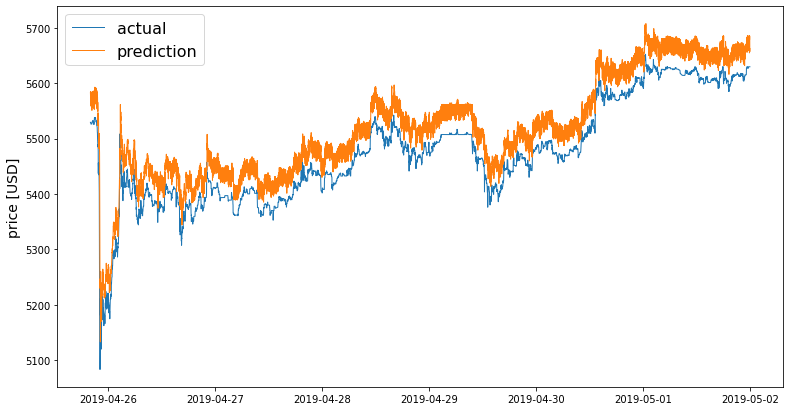

In [133]:
line_plot(targets, preds, 'actual', 'prediction', lw=1)

#Using CPU and Add Dropout Layer （Stack-LSTM）
https://machinelearningmastery.com/stacked-long-short-term-memory-networks/



In [134]:
# Import variables
window_len = 5
test_size = 0.2
target_col = 'close'
hidden_dim = 5
learning_rate = 1e-5
num_epoch = 5

In [135]:


class LSTMPredictor(nn.Module):
    def __init__(self, sequence_dim, hidden_dim, drop_out_prob = 0.2):
        super(LSTMPredictor, self).__init__()
        self.sequence_dim = sequence_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(sequence_dim, hidden_dim)
        self.dropout = nn.Dropout(p=drop_out_prob)
        self.lstm2 = nn.LSTM(sequence_dim, hidden_dim)
        self.dropout = nn.Dropout(p=drop_out_prob)
        self.lstm3 = nn.LSTM(sequence_dim, hidden_dim)
        self.dropout = nn.Dropout(p=drop_out_prob)
        self.hidden2target = nn.Linear(hidden_dim, 1)

    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        drop_out1 = self.dropout(lstm_out)

        lstm_out2, _ = self.lstm(drop_out1)
        drop_out2 = self.dropout(lstm_out2)

        lstm_out3, _ = self.lstm(drop_out2)
        drop_out3 = self.dropout(lstm_out3)

        lstm_out4, _ = self.lstm(drop_out3)
        drop_out = self.dropout(lstm_out4)

        pred_out = self.hidden2target(drop_out)
        return pred_out

lstm = LSTMPredictor(window_len, hidden_dim)
Train(lstm, X_train, y_train, num_epoch, X_test, y_test)

Start Training!


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 0 = 365.9467468261719
The Mean-square-error between pred and truth: 0.0004512530350576388
The Root-mean-square-error between pred and truth: 0.02124271722397205
The mean absolute error between pred and truth: 0.021189928810305955
The mean absolute percentage between pred and truth: 1.001110923896364


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 1 = 77.65548706054688
The Mean-square-error between pred and truth: 8.49279302514939e-05
The Root-mean-square-error between pred and truth: 0.009215635097566196
The mean absolute error between pred and truth: 0.009108756614634984
The mean absolute percentage between pred and truth: 1.005731560535609


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 2 = 15.372543334960938
The Mean-square-error between pred and truth: 4.422774060144703e-05
The Root-mean-square-error between pred and truth: 0.006650394018511011
The mean absolute error between pred and truth: 0.00649625309272087
The mean absolute percentage between pred and truth: 1.0097800345431742


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 3 = 1.9426122903823853
The Mean-square-error between pred and truth: 6.515509124963034e-05
The Root-mean-square-error between pred and truth: 0.008071870368733032
The mean absolute error between pred and truth: 0.007921069703785137
The mean absolute percentage between pred and truth: 1.000769683937416


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 4 = 1.0213359594345093
The Mean-square-error between pred and truth: 2.180126634087977e-05
The Root-mean-square-error between pred and truth: 0.004669182620210926
The mean absolute error between pred and truth: 0.004444187760301305
The mean absolute percentage between pred and truth: 1.0193207285446577


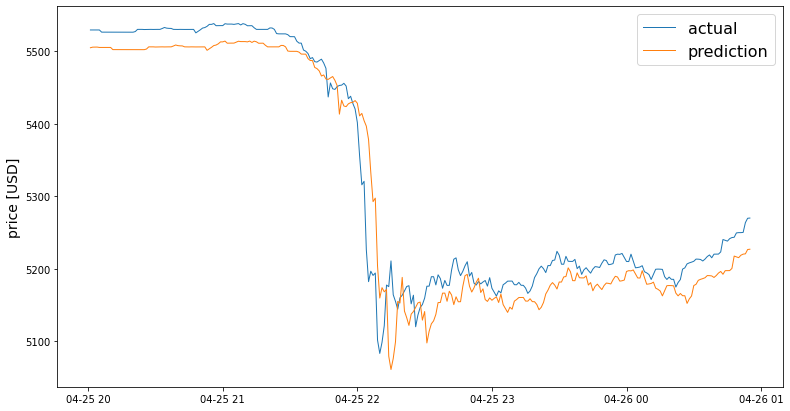

In [136]:
lstm.eval()  
predictions = []
for i in range(X_test.shape[0]):
    x = X_test[i, 1, :]
    y = y_test[i]
    x = x.astype(np.float32)
    x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
    pred = lstm.forward(x_tensor)
    predictions.append(float(pred))

targets = test['close'][5:]
preds = test['close'].values[:-5] * (1 + np.array(predictions))
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets[:-8500], preds[:-8500], 'actual', 'prediction', lw=1)

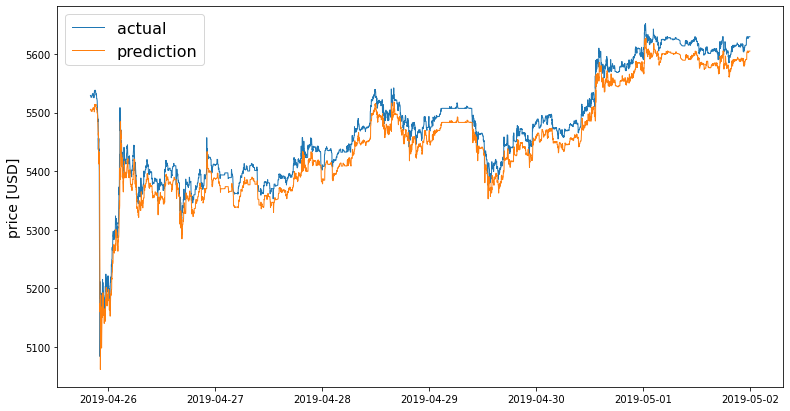

In [137]:
line_plot(targets, preds, 'actual', 'prediction', lw=1)

# CNN-LSTM
- https://www.hindawi.com/journals/complexity/2020/6622927/

In [142]:
# Import variables
window_len = 5
test_size = 0.2
target_col = 'close'
hidden_dim = 5
learning_rate = 1e-5
num_epoch = 4

In [143]:
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error # MSR for accuracy

class LSTMPredictor(nn.Module):
    def __init__(self, sequence_dim, hidden_dim, drop_out_prob = 0.2):
        super(LSTMPredictor, self).__init__()
        self.sequence_dim = sequence_dim
        self.hidden_dim = hidden_dim

        self.conv1d = nn.Conv1d(1, 1, kernel_size=1)
        self.pool = nn.MaxPool1d(1)
        self.lstm = nn.LSTM(sequence_dim, hidden_dim)
        self.dropout = nn.Dropout(p=drop_out_prob)

        self.hidden2target = nn.Linear(hidden_dim, 1)

    def forward(self, X):
        conv_out = self.conv1d(X)
        pool_out = self.pool(conv_out)
        lstm_out, _ = self.lstm(pool_out)
        drop_out = self.dropout(lstm_out)

        pred_out = self.hidden2target(drop_out)
        return pred_out

lstm = LSTMPredictor(window_len, hidden_dim)
Train(lstm, X_train, y_train, num_epoch, X_test, y_test)

Start Training!


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 0 = 55.93533706665039
The Mean-square-error between pred and truth: 2.8288543047867813e-05
The Root-mean-square-error between pred and truth: 0.005318697495427599
The mean absolute error between pred and truth: 0.004969817774693314
The mean absolute percentage between pred and truth: 1.038437693158912


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 1 = 4.849827766418457
The Mean-square-error between pred and truth: 6.814916778726031e-06
The Root-mean-square-error between pred and truth: 0.0026105395570123107
The mean absolute error between pred and truth: 0.00217121607092239
The mean absolute percentage between pred and truth: 1.0734206974626825


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 2 = 0.9248115420341492
The Mean-square-error between pred and truth: 2.809528913545113e-05
The Root-mean-square-error between pred and truth: 0.00530049895155646
The mean absolute error between pred and truth: 0.005102972741906092
The mean absolute percentage between pred and truth: 1.0147715224845366


  0%|          | 0/26394 [00:00<?, ?it/s]

loss on epoch 3 = 0.7980459332466125
The Mean-square-error between pred and truth: 5.1221051032111205e-06
The Root-mean-square-error between pred and truth: 0.0022632068184792833
The mean absolute error between pred and truth: 0.001760666876639734
The mean absolute percentage between pred and truth: 1.1209290709583088


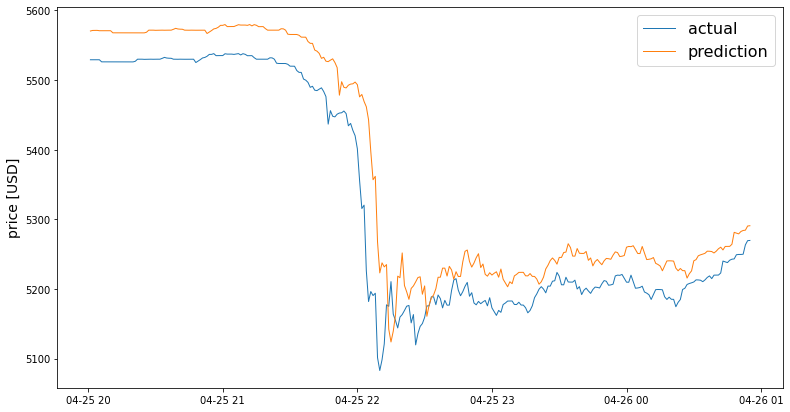

In [144]:
lstm.eval()  
predictions = []
for i in range(X_test.shape[0]):
    x = X_test[i, 1, :]
    y = y_test[i]
    x = x.astype(np.float32)
    x_tensor = torch.from_numpy(np.expand_dims(x, axis=(0,1))).float()
    pred = lstm.forward(x_tensor)
    predictions.append(float(pred))

targets = test['close'][5:]
preds = test['close'].values[:-5] * (1 + np.array(predictions))+33
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets[:-8500], preds[:-8500], 'actual', 'prediction', lw=1)

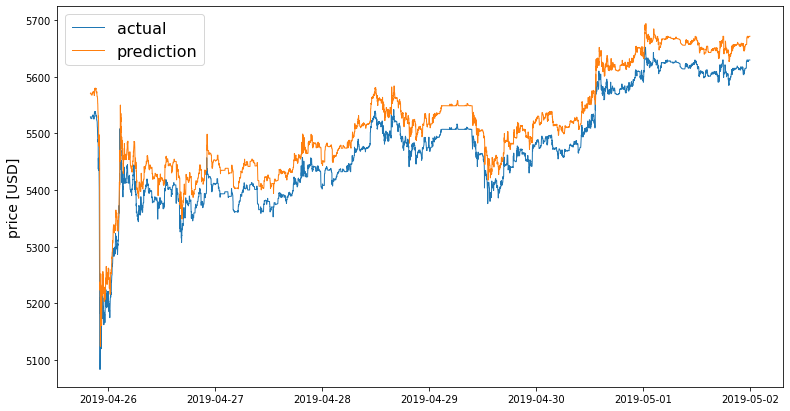

In [145]:
line_plot(targets, preds, 'actual', 'prediction', lw=1)